In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm_notebook as tqdm
import geopandas as gpd

%matplotlib notebook
%run network.py

In [7]:
gdf = gpd.read_file('data/NYC Street Centerline (CSCL).geojson')
manhattan = gdf[gdf['borocode'] == '1']

In [8]:
manhattan.head()

,rw_type,l_low_hn,pre_direct,st_width,r_zip,r_low_hn,bike_lane,post_type,r_blkfc_id,bike_trafd,...,snow_pri,borocode,trafdir,pre_modifi,st_label,physicalid,st_name,created,l_high_hn,geometry
16,8,,,28,10040,,,,1322600323,,...,,1,TW,,DRIVEWAY,170875,DRIVEWAY,2015-12-15T00:00:00,,(LINESTRING (-73.92252465335248 40.85951850445...
61,1,63,,14,10004,63,,ST,212260710,,...,H,1,FT,,STONE ST,488,STONE,2007-11-29T00:00:00,69,(LINESTRING (-74.01006968341342 40.70454591413...
65,1,17,,14,10038,17,,ST,212260051,,...,H,1,TF,,GOLD ST,79723,GOLD,2007-11-29T00:00:00,25,(LINESTRING (-74.0068377870997 40.707857835737...
93,1,1,E,30,10029,9,,ST,1322606181,,...,C,1,TF,,E 109 ST,179568,109,2007-11-29T00:00:00,7,(LINESTRING (-73.94968682996546 40.79621698487...
96,1,,,60,10033,,3,AVE,1322608388,TW,...,C,1,TW,,AMSTERDAM AV,3904,AMSTERDAM,2007-11-29T00:00:00,,(LINESTRING (-73.93191507377053 40.84671052361...


## Check validity of intersection coordinates

<IPython.core.display.Javascript object>


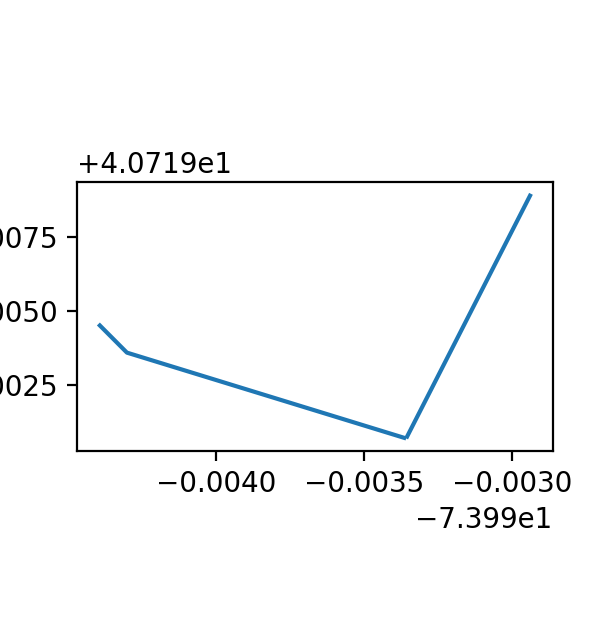

In [134]:
manhattan[manhattan["physicalid"].isin(["4040", "16696"])]["geometry"].plot()

In [222]:
a = manhattan[manhattan["physicalid"] == "4040"]["geometry"]
_, a_end = a.iloc[0].boundary

In [226]:
b = manhattan[manhattan["physicalid"] == "16696"]["geometry"]
b_end, _ = b.iloc[0].boundary

In [228]:
a_end.coords.xy == b_end.coords.xy

True

## Construct network

In [301]:
# coordinates of the intersections, stored as tuples
intersectionCoords = []
# format the coords as tuples
f = lambda x: (x.coords.xy[0][0], x.coords.xy[1][0])
# add unique elements to list
addToList = lambda x, lst: lst.append(x) if x not in lst else pass

for index, row in manhattan.iterrows():
    if row["trafdir"] != "NV":
        try:
            coord1, coord2 = row["geometry"].boundary
            addToList(f(coord1), intersectionCoords)
            addToList(f(coord2), intersectionCoords)
        except ValueError:
            ()

In [302]:
network = Network(intersectionCoords)

In [303]:
intersectionID = dict(zip(intersectionCoords, range(len(intersectionCoords))))
for index, row in manhattan.iterrows():
    if row["trafdir"] != "NV":
        try:
            coord1, coord2 = row["geometry"].boundary
            network.add_streets_from_nodes(intersectionID[f(coord1)],
                                           intersectionID[f(coord2)],
                                           row["trafdir"] == "TW")
        except ValueError:
            pass

<IPython.core.display.Javascript object>


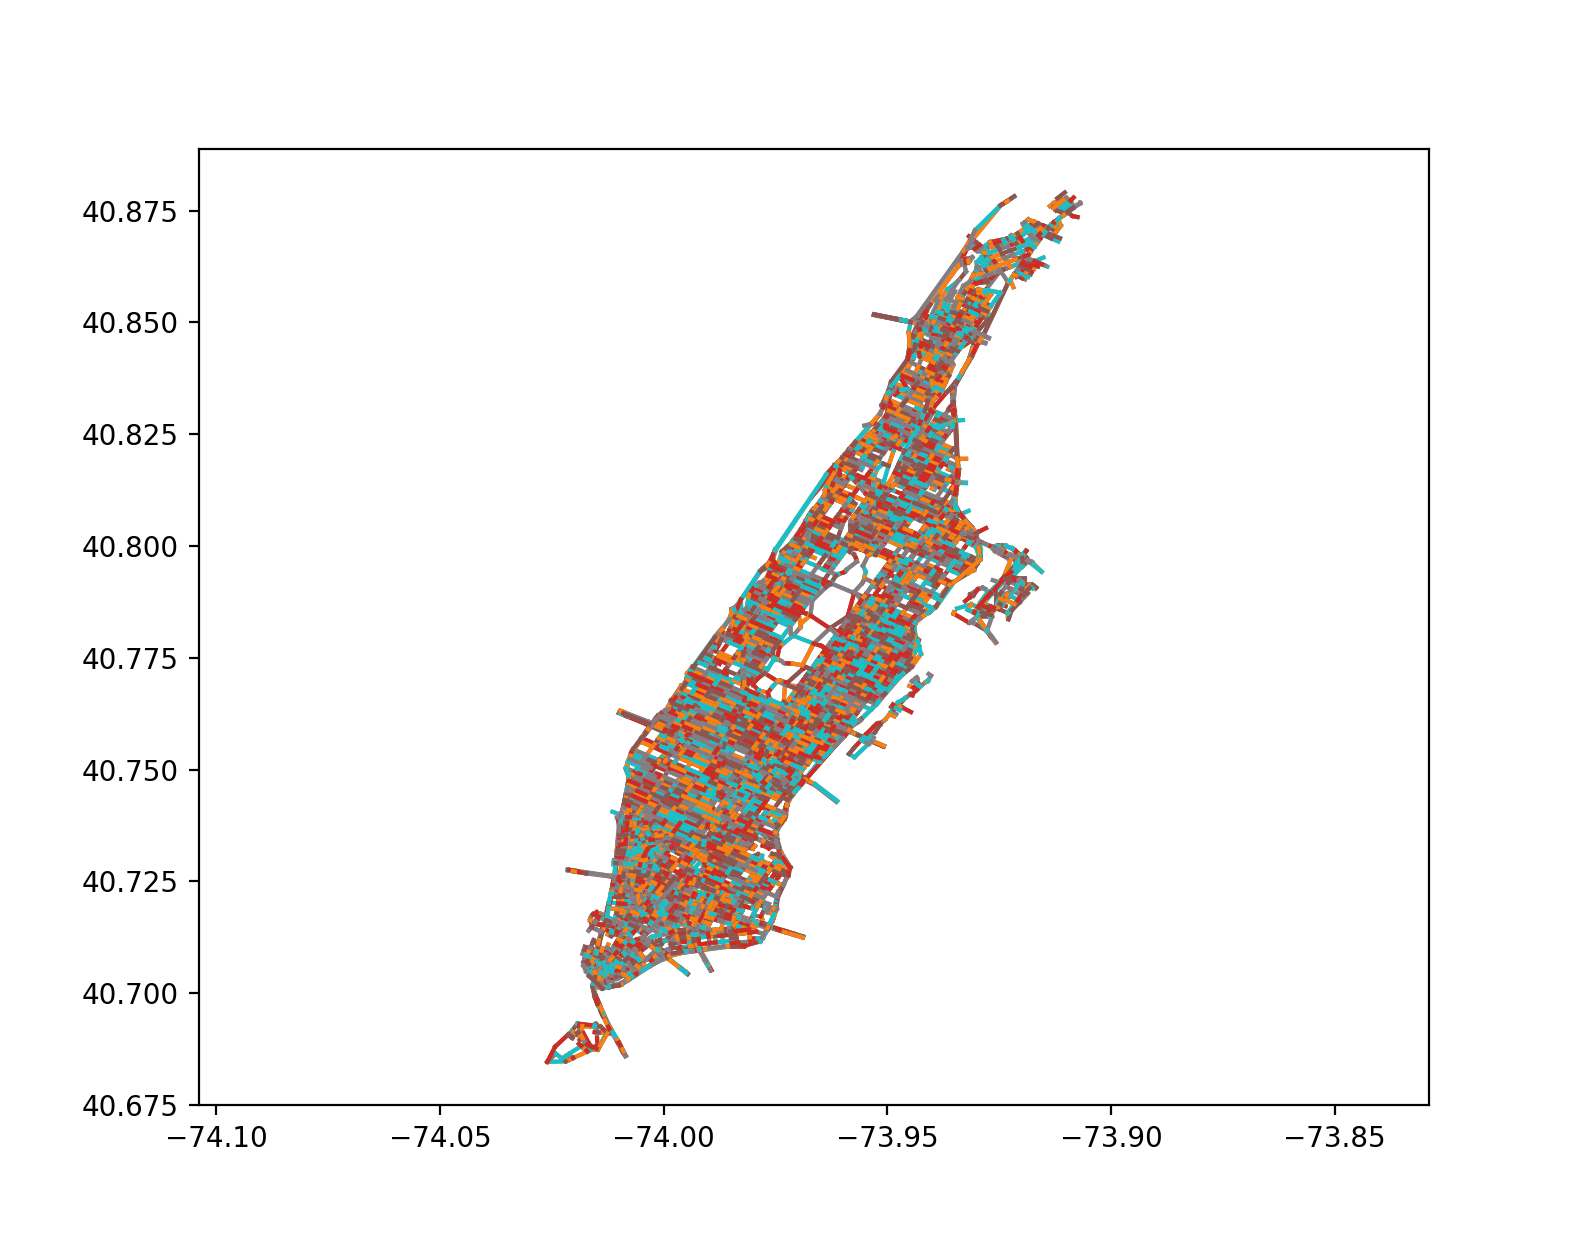

100%|██████████| 22462/22462 [07:58<00:00, 46.90it/s] 


In [313]:
plt.figure()
plt.axis('equal')
for street in tqdm(network.streets):
    n1 = network.nodes[street.start]
    n2 = network.nodes[street.end]
    x1, y1 = n1.coord
    x2, y2 = n2.coord
    plt.plot([x1, x2], [y1, y2])

## Detect one way street

In [314]:
street1 = manhattan[manhattan["physicalid"] == "19473"]["geometry"]

In [356]:
def process(x):
    _, row = x
    try:
        coord1, coord2 = row["geometry"].boundary
        return f(coord1)
    except ValueError:
        pass

In [372]:
# a dictionary of the coordinates of intersections to the physical IDs
# of the streets that are connected to this intersection
intersectionToStreet = dict()

def addRecord(x, id_, dict_):
    try:
        dict_[f(x)].append(id_)
    except KeyError:
        dict_[f(x)] = [id_]

for index, row in manhattan.iterrows():
    try:
        coord1, coord2 = row["geometry"].boundary
        addRecord(coord1, row["physicalid"], intersectionToStreet)
        addRecord(coord2, row["physicalid"], intersectionToStreet)
    except ValueError:
        pass

In [381]:
for index, row in tqdm(manhattan.iterrows()):
    if row["trafdir"] in ["TF", "FT"]:
        try:
            mark = False
            coord1, coord2 = row["geometry"].boundary
            for physicalID in intersectionToStreet[f(coord1)]:
                street = manhattan[manhattan["physicalid"] == physicalID].iloc[0]
                if abs(int(street["physicalid"]) - int(physicalID)) < 50:
                    mark = True
            for physicalID in intersectionToStreet[f(coord2)]:
                street = manhattan[manhattan["physicalid"] == physicalID].iloc[0]
                if abs(int(street["physicalid"]) - int(physicalID)) < 50:
                    mark = True        
        except ValueError:
            pass
print(good)
print(bad)

11681it [02:42, 72.03it/s]

KeyboardInterrupt: 

In [382]:
print(good)
print(bad)

7573
0


11681it [03:00, 64.84it/s]